# Import librarly

In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import numpy as np
import random

# Read dataset

In [2]:
# Do not separate by a comma if there is no space after the comma
# If you use a regular expression as a delimiter, you need to specify the Python engine
twitterData = pd.read_csv("data.csv", sep=',(?=\S)', engine='python')

twitterData.head()

,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,"""1969527638""","""LlngoMakeEmCum_""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/534286217...",319,112,"""en""",1472271687519,"""769310701580083200""","[ ""1969574754"", ""1969295556"", ""1969284056"", ""1..."
1,"""51878493""","""_notmichelle""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/761977602...",275,115,"""en""",1472270622663,"""769309490038439936""","[ ""60789485"", ""2420931980"", ""2899776756"", ""127..."
2,"""1393409100""","""jesseayye""","[ ""#narcos"" ]","""http://pbs.twimg.com/profile_images/713282938...",120,107,"""en""",1472804144409,"""771622623583186944""","[ ""86868062"", ""19697415"", ""2998836604"", ""45629..."
3,"""232891415""","""MrBrianLloyd""","[ ""#gloryoutnow"" ]","""http://pbs.twimg.com/profile_images/133440668...",492,325,"""en""",1472269186776,"""769308131696467969""","[ ""361335082"", ""1405248468"", ""24626354"", ""7256..."
4,"""710130422907207680""","""sarahdorat_16""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/767180520...",128,218,"""en""",1472271397356,"""769309769144283137""","[ ""1571896093"", ""768938323612008448"", ""2548665..."


## Modify dataset

In [3]:
# 1. removing unnecessary double quotes
twitterData["id"] = twitterData["id"].apply(lambda x: x[1:-1])
    
# 2. The list of friends (people followed) is saved as a single string. To convert it to a list of friend IDs, use a JSON loader.
for column in ["tags", "friends"]:
    twitterData[column] = twitterData[column].apply(lambda x: json.loads(x))

# 3. drop unused column for this project
twitterData = twitterData.drop(["lang", 'avatar', 'tweetId', 'screenName', 'lastSeen'], axis=1)

twitterData.head()

,id,tags,followersCount,friendsCount,friends
0,1969527638,[#nationaldogday],319,112,"[1969574754, 1969295556, 1969284056, 196961221..."
1,51878493,[#nationaldogday],275,115,"[60789485, 2420931980, 2899776756, 127410795, ..."
2,1393409100,[#narcos],120,107,"[86868062, 19697415, 2998836604, 456295047, 74..."
3,232891415,[#gloryoutnow],492,325,"[361335082, 1405248468, 24626354, 725675895965..."
4,710130422907207680,[#nationaldogday],128,218,"[1571896093, 768938323612008448, 2548665930, 3..."


In [4]:
twitterData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40000 non-null  object
 1   tags            40000 non-null  object
 2   followersCount  40000 non-null  int64 
 3   friendsCount    40000 non-null  int64 
 4   friends         40000 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


# Prerpocess

In [5]:
# friends: the list of IDs the user follows
# friendsCount: the length of the friends list
twitterData.describe()

,followersCount,friendsCount
count,4.000000e+04,40000.000000
mean,3.692349e+03,919.101450
std,9.136179e+04,3417.849318
min,1.010000e+02,101.000000
25%,2.420000e+02,253.000000
50%,4.400000e+02,423.000000
75%,9.240000e+02,801.000000
max,1.476555e+07,238749.000000


In [6]:
# create a dictionary to find index from id
id_index_dict = {}
for index, row in twitterData.iterrows():
    id_index_dict[row['id']] = index

In [7]:
# show the number of nodes, edges and the number of communities
def print_graph_summary(G):
    print("Number of nodes: {}".format(G.number_of_nodes()))
    print("Number of edges: {}".format(G.number_of_edges()))
    # detect communities
    communities = list(nx.community.greedy_modularity_communities(G))
    print("Number of communities: {}".format(len(communities)))
    return communities

### Create a Graph with the random sampling method

In [8]:
# create directed graph: the node is the user, the edge is the connection between users
G = nx.DiGraph()
G_rand = nx.DiGraph()

for _, row in twitterData.iterrows():
    for friend in row['friends']:
        # ignore the users who are not in this dataset
        if friend in id_index_dict:
            G.add_edge(row['id'], friend)
            G_rand.add_edge(row['id'], friend)
            
num_sampled_nodes = 1633
all_nodes = list(G.nodes())
sampled_nodes = random.sample(all_nodes, num_sampled_nodes)
G = G.subgraph(sampled_nodes)
            
# show the number of nodes and edges
communities = print_graph_summary(G)

Number of nodes: 1633
Number of edges: 494
Number of communities: 1270


# Network Characterization

In [9]:
# print number of nodes and edges with format
print("Number of nodes: {}\n".format(G.number_of_nodes()))
print("Number of edges: {}\n".format(G.number_of_edges()))

Number of nodes: 1633

Number of edges: 494



In [10]:
# find the five nodes with the highest clustering coefficients with format
hi_clustring_coeff = sorted(nx.clustering(G).items(), key=lambda x: x[1], reverse=True)[:5]

# find the five nodes with the highest betweenness centrality with format
hi_betweeness_cen = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

In [11]:
# enumerate the five nodes with the highest clustering coefficients
for i, (node, coeff) in enumerate(hi_clustring_coeff):
    # get index from id
    index = id_index_dict[node]
    print("{}. clustering coefficient: {}".format(i+1, coeff))
    # print the row of the node
    print(twitterData.iloc[index])
    print()

1. clustering coefficient: 1.0
id                                                       2669441698
tags                                                 [#gloryoutnow]
followersCount                                                  686
friendsCount                                                    299
friends           [73218324, 245932184, 153176598, 2610502981, 3...
Name: 28299, dtype: object

2. clustering coefficient: 1.0
id                                                       3389673461
tags                                          [#respecttylerjoseph]
followersCount                                                  138
friendsCount                                                    400
friends           [711231466445938689, 16712746, 763503874149715...
Name: 31151, dtype: object

3. clustering coefficient: 1.0
id                                                       2585414326
tags                         [#nationaldogday, #respecttylerjoseph]
followersCount                     

In [12]:
# enumerate the five nodes with the highest betweenness centrality
for i, (node, betweenness) in enumerate(hi_betweeness_cen):
    # get index from id
    index = id_index_dict[node]
    print("{}. betweenness centrality: {}".format(i+1, betweenness))
    # print the row of the node
    print(twitterData.iloc[index])
    print()

1. betweenness centrality: 4.50824106466621e-05
id                                                        394216985
tags                             [#nationaldogday, #backtohogwarts]
followersCount                                               340610
friendsCount                                                   2927
friends           [32799740, 166314913, 274055708, 26133470, 199...
Name: 25445, dtype: object

2. betweenness centrality: 3.287259109652445e-05
id                                                        507524916
tags                                              [#nationaldogday]
followersCount                                                31307
friendsCount                                                  34421
friends           [449392023, 1209301026, 767742832488673280, 22...
Name: 1515, dtype: object

3. betweenness centrality: 2.5922386121830707e-05
id                                                        211643924
tags                                              

In [13]:
# print number of connected components with format
print("Number of connected components: {}".format(nx.number_connected_components(G.to_undirected())))
# print the diameter of the graph with format
for i, component in enumerate(nx.connected_components(G.to_undirected())):
    print("Diameter of the component {}: {}".format(i + 1, nx.diameter(G.subgraph(component).to_undirected())))

Number of connected components: 1261
Diameter of the component 1: 0
Diameter of the component 2: 1
Diameter of the component 3: 0
Diameter of the component 4: 0
Diameter of the component 5: 19
Diameter of the component 6: 0
Diameter of the component 7: 0
Diameter of the component 8: 0
Diameter of the component 9: 0
Diameter of the component 10: 2
Diameter of the component 11: 0
Diameter of the component 12: 0
Diameter of the component 13: 0
Diameter of the component 14: 0
Diameter of the component 15: 0
Diameter of the component 16: 0
Diameter of the component 17: 0
Diameter of the component 18: 0
Diameter of the component 19: 0
Diameter of the component 20: 0
Diameter of the component 21: 0
Diameter of the component 22: 1
Diameter of the component 23: 0
Diameter of the component 24: 2
Diameter of the component 25: 0
Diameter of the component 26: 0
Diameter of the component 27: 0
Diameter of the component 28: 0
Diameter of the component 29: 0
Diameter of the component 30: 0
Diameter of

### Visualization

In [14]:
# combine the nodes in communities
community_dict = {node: -1 for node in G.nodes()}
community_dict = {node: cid for cid, community in enumerate(communities) for node in community}

# set the color of nodes
colors = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys())
node_color = [colors[community_dict[node] % len(colors)] for node in G.nodes()]

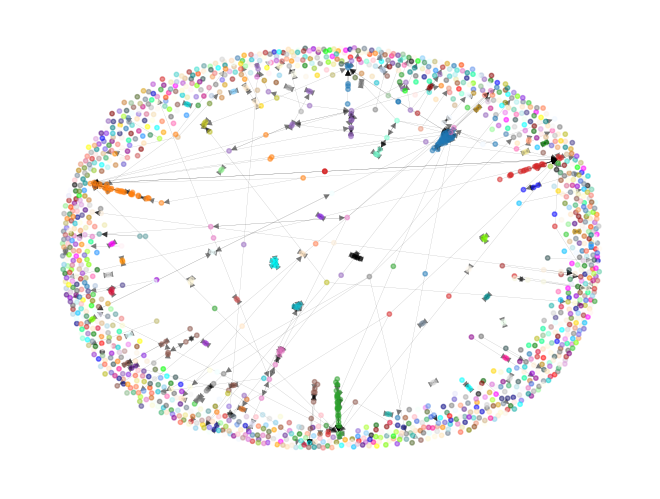

In [15]:
nx.draw(G, node_color=node_color, with_labels=False, node_size=10, alpha=0.5, width=0.1)
plt.show()